# Running Wflow using the ewatercycle system

### 1. Copy an example case
To run WFlow, we need a complete parameterset. The easiest way to obtain a valid model configuration is by copying it from https://github.com/openstreams/wflow/raw/master/examples/. We can use `ewatercycle.parametersetdb` to easily copy on of these example cases to a folder called `./wflow_example_case`.

In [ ]:
from ewatercycle.parametersetdb import build_from_urls

# Obtain an example case for testing the model
parameterset = build_from_urls(
    config_format='ini', config_url='https://github.com/openstreams/wflow/raw/master/examples/wflow_rhine_sbm_nc/wflow_sbm_NC.ini',
    datafiles_format='svn', datafiles_url='https://github.com/openstreams/wflow/trunk/examples/wflow_rhine_sbm_nc',
)
parameterset.save_datafiles('./wflow_example_case_nc')

### 2. Verify your configuration settings

If you are working on a curated environment like https://lab.ewatercycle.org/, the default configuration should cover 90% of all use cases. However, for the other 10% here is a brief explanation of the relevant configuration settings. 

The ewatercycle configuration file is typcially stored in `~/ewatercycle/ewatercycle.yaml` or `/etc/ewatercycle.yaml` and can be imported with `from ewatercycle import CFG`. Relevant settings for WFLow are:

```Yaml
container_engine: docker # or singularity
singularity_dir: './' # the directory where singularity images are stored
output_dir: './' # the directory where the model work_dir will be created
```

In order for this to work, you need to make sure that the actual docker or singularity images are available on the system. This can be done with:

- Docker: `docker pull ewatercycle/wflow-grpc4bmi:latest`
- Singularity: `singularity build --disable-cache ewatercycle-wflow-grpc4bmi.sif docker://ewatercycle/wflow-grpc4bmi:latest`

### 3. Setting up the model

In [1]:
import ewatercycle.models
ewatercycle.models.Wflow.available_versions

/home/peter/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/_warnings.py:18: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498
/home/peter/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/config/_config_validators.py:254: ESMValToolDeprecationWarning: `write_plots` will be removed in 2.4.0.
/home/peter/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/config/_config_validators.py:255: ESMValToolDeprecationWarning: `write_netcdf` will be removed in 2.4.0.


'2020.1.1'

In [2]:
parameter_set = ewatercycle.models.wflow.WflowParameterSet(
    input_data = "./wflow_example_case_nc/",
    default_config = "./wflow_example_case_nc/wflow_sbm_NC.ini",
)
parameter_set

WflowParameterSet(input_data=PosixPath('/home/peter/ewatercycle/ewatercycle/examples/wflow_example_case_nc'), default_config=PosixPath('/home/peter/ewatercycle/ewatercycle/examples/wflow_example_case_nc/wflow_sbm_NC.ini'))

In [3]:
import ewatercycle.forcing
forcing = ewatercycle.forcing.load_foreign(
    target_model = 'wflow',
    start_time = '1991-01-01T00:00:00Z',
    end_time = '1991-12-31T00:00:00Z',
    forcing_info = dict(
        netcdfinput = '../test_forcing_data.nc',
        Precipitation = "/P",
        EvapoTranspiration = "/PET",
        Temperature = "/TEMP"
    )
)
forcing

WflowForcing(start_time='1991-01-01T00:00:00Z', end_time='1991-12-31T00:00:00Z', directory='.', shape=None, netcdfinput=PosixPath('/home/peter/ewatercycle/ewatercycle/test_forcing_data.nc'), Precipitation='/P', EvapoTranspiration='/PET', Temperature='/TEMP', Inflow=None)

In [4]:
model = ewatercycle.models.Wflow(version='2020.1.1', parameter_set=parameter_set, forcing=forcing)

In [5]:
model.parameters

[('inputmapstacks',
  {'Precipitation': '/P',
   'EvapoTranspiration': '/PET',
   'Temperature': '/TEMP',
   'Inflow': '/inmaps/IF'}),
 ('modelparameters', {}),
 ('run',
  {'starttime': '1991-02-01 00:00:00',
   'endtime': '1991-03-01 00:00:00',
   'timestepsecs': '86400',
   'reinit': '1'}),
 ('model',
  {'modeltype': 'sbm',
   'AnnualDischarge': '2290',
   'Alpha': '120',
   'ModelSnow': '0',
   'ScalarInput': '0',
   'InterpolationMethod': 'inv',
   'WIMaxScale': '0.8',
   'Tslice': '1',
   'UpdMaxDist': '300000.0',
   'origTopogLateral': '1'}),
 ('misc', {}),
 ('framework',
  {'netcdfoutput': 'outmaps.nc',
   'netcdfinput': 'test_forcing_data.nc',
   'netcdfwritebuffer': '10',
   'netcdf_least_significant_digit': '2'}),
 ('layout', {'sizeinmetres': '0'}),
 ('outputmaps',
  {'self.Inflow': 'iflow',
   'self.RiverRunoff': 'run',
   'self.InwaterMM': 'iwm',
   'self.PotenEvap': 'PET',
   'self.Precipitation': 'P'}),
 ('summary', {'self.MaxLeakage': 'MaxLeakage.map'}),
 ('summary_sum',

In [6]:
cfg_file, cfg_dir = model.setup(
    API = {"RiverRunoff": "2, m^3/s"},
    run = {"starttime": "1995-01-31 00:00:00 GMT", "endtime": "1995-02-27 00:00:00 GMT"},
#     framework = {"netcdfinput": "/home/peter/some_other_dataset.nc"},  # if absolute path exists, it will be copied to work dir
)

In [7]:
cfg_file, cfg_dir

(PosixPath('/home/peter/ewatercycle/ewatercycle/examples/wflow_20210601_114152/wflow_ewatercycle.ini'),
 PosixPath('/home/peter/ewatercycle/ewatercycle/examples/wflow_20210601_114152'))

### 4. Running the model

In [9]:
cfg_file

PosixPath('/home/peter/ewatercycle/ewatercycle/examples/wflow_20210601_114152/wflow_ewatercycle.ini')

In [10]:
# This conversion to string shouldn't be necessary
model.initialize(str(cfg_file))

In [11]:
model.get_value("RiverRunoff")  # WFlow interally uses a fill-value for masked data of -999

array([-999., -999., -999., ..., -999., -999., -999.])

In [12]:
model.get_value_as_xarray("RiverRunoff")  # this automatically converts the -999 values to NaN

<xarray.DataArray 'RiverRunoff' (latitude: 169, longitude: 187)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 45.89 45.93 45.97 46.0 ... 51.98 52.02 52.05
    time       object 1995-01-30 00:00:00
Attributes:
    units:     m^3/s

In [13]:
while model.time < model.end_time:
    print(model.time)
    model.update()

791424000.0
791510400.0
791596800.0
791683200.0
791769600.0
791856000.0
791942400.0
792028800.0
792115200.0
792201600.0
792288000.0
792374400.0
792460800.0
792547200.0
792633600.0
792720000.0
792806400.0
792892800.0
792979200.0
793065600.0
793152000.0
793238400.0
793324800.0
793411200.0
793497600.0
793584000.0
793670400.0
793756800.0


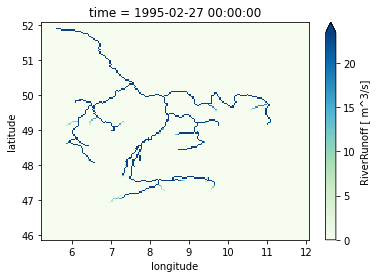

In [14]:
da = model.get_value_as_xarray("RiverRunoff")
da.plot(robust=True, cmap='GnBu')

In [15]:
model.finalize()

In [16]:
del(model)